# Introduction

This project came to life when I, out of the blue, hit a serious case of certification fatigue. I had been in the IT consultant industry for 6 months, and it had been 6 months taking various courses, with a pressure of getting as many certifications as I could. 

For a long time I had enjoyed it a lot, learning things I had had on my to-do-list for years. But this day, my brain said stop. So I decided that it was time to shift focus, experiment, and play around with everything I had learnt so far, focusing on having fun.

I decided that whatever I was to spend the next days or weeks on, it should ideally not be *useful*. 

After searhing around for a good dataset, I ended up with these two similar data sets from Stavanger. They are open for the public. They contain data on the hourly coverage/usage of different parking spots in Stavanger. There is a datapoint for each our every day for each parking lot. One dataset contains the data from 2017, the other from 2018. 

## Preliminaries 

In [395]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

#some variables that will be useful later on:
parkinglots = ['Siddis', 'Forum', 'Jernbanen', 'Posten', 'Jorenholmen', 'St. Olav', 'Valberget', 'Kyrre', 'Parketten']
colors = ['teal', 'green', 'red', 'blue', 'grey', 'purple', 'orange', 'yellow', 'pink']
colors2 = ['red', 'pink', 'teal', 'orange', 'purple', 'grey', 'blue', 'green', 'green']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
hours = ['00','01','02','03','04','05','06','07','08','09', '10','11','12','13','14','15','16','17','18','19','20','21','22','23']
hours_every_other = ['00',' ','02',' ','04',' ','06',' ','08',' ','10',' ','12',' ','14',' ','16',' ','18',' ','20',' ','22', ' ']
hours_every_four = ['','01',' ',' ','','05',' ',' ','','09','',' ','','13','',' ','','17','',' ','','21','', ' ']


def fix_date(date):
    '''
    A helper function that reformats the Dates to a format that can then be converted to a datetime object
    '''
    day = str(date[0])
    month= str(date[1])
    year = '20' + str(date[2])
    
    if month == 'mai':
        month = 'may'
    elif month == 'okt':
        month = 'oct'
    elif month == 'des':
        month = 'dec'
    return year + '-' + month + '-' + day

## 2018: reading and cleaning

In [375]:
parkering2018 = pd.read_csv('parkering2018.csv')
parkering2018.head()

,Dato,Tid,Siddis,Forum,Jernbanen,Posten,Jorenholmen,St. Olav,Valberget,Kyrre,Parketten
0,1-jan-18,0:00,"3,0","0,0","19,0","11,0","17,0","22,0","12,0","14,0","13,0"
1,1-jan-18,1:00,"3,0","0,0","18,0","5,0","14,0","21,0","10,0","15,0","13,0"
2,1-jan-18,2:00,"2,0","0,0","17,0","6,0","15,0","21,0","6,0","15,0","4,0"
3,1-jan-18,3:00,"2,0","0,0","17,0","5,0","15,0","21,0","6,0","15,0","3,0"
4,1-jan-18,4:00,"2,0","0,0","17,0","5,0","15,0","21,0","6,0","15,0","3,0"


In [376]:
#Fixing the dates, and adding date+time in a seperate column as a datetime object
parkering2018['Dato'] = parkering2018['Dato'].str.split('-')
parkering2018['Tidspunkt'] = parkering2018['Dato'].apply(fix_date) + ' ' + parkering2018['Tid'] #collecting date + time into a separate column
parkering2018['Tidspunkt'] = pd.to_datetime(parkering2018['Tidspunkt']) #converting the new column to datetime

# Converting the numericals to ratios (floating numbers between 0 and 1)
for lot in parkinglots:
    parkering2018[lot] = parkering2018[lot].str.replace(',','.')
    parkering2018[lot] = parkering2018[lot].astype('float32')
    parkering2018[lot] = parkering2018[lot]/100

#adding a couple of extra columns for future ease. No new information here, just a better setup for visualisations below
parkering2018['Month'] = parkering2018['Tidspunkt'].dt.month # jan=1, ..., dec=12
parkering2018['Hour'] = parkering2018['Tid'].str.split(':').str[0].astype('int32')

#previewing the final dataframe:
parkering2018.head()

C:\Users\lenelise\AppData\Local\Temp\ipykernel_12084\3330570043.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,Dato,Tid,Siddis,Forum,Jernbanen,Posten,Jorenholmen,St. Olav,Valberget,Kyrre,Parketten,Tidspunkt,Month,Hour
0,"[1, jan, 18]",0:00,0.03,0.0,0.19,0.11,0.17,0.22,0.12,0.14,0.13,2018-01-01 00:00:00,1,0
1,"[1, jan, 18]",1:00,0.03,0.0,0.18,0.05,0.14,0.21,0.10,0.15,0.13,2018-01-01 01:00:00,1,1
2,"[1, jan, 18]",2:00,0.02,0.0,0.17,0.06,0.15,0.21,0.06,0.15,0.04,2018-01-01 02:00:00,1,2
3,"[1, jan, 18]",3:00,0.02,0.0,0.17,0.05,0.15,0.21,0.06,0.15,0.03,2018-01-01 03:00:00,1,3
4,"[1, jan, 18]",4:00,0.02,0.0,0.17,0.05,0.15,0.21,0.06,0.15,0.03,2018-01-01 04:00:00,1,4


## 2017: reading and cleaning
Mostly the same steps as for 2018. We uncovered one error in the dataset, which we needed to account for. It was the registration for Feb 15th 02:00, which was done at 02:01 instead. We replaced 02:01 woth 02:00, as the error caused issues down the line when we wanted to group the data on `Tid`.

In [377]:
parkering2017 = pd.read_csv('parkering2017.csv')
parkering2017['Dato'] = parkering2017['Dato'].str.split('-')
# print(parkering2017.isna().sum())
parkering2017 = parkering2017.dropna() #one row with pure NaN
parkering2017.head()

,Dato,Tid,Siddis,Forum,Jernbanen,Posten,Jorenholmen,St. Olav,Valberget,Kyrre,Parketten
0,"[1, jan, 17]",0:00,"2,0","0,0","16,0","15,0","15,0","21,0","8,0","18,0","4,0"
1,"[1, jan, 17]",1:00,"2,0","0,0","11,0","6,0","12,0","19,0","7,0","17,0","4,0"
2,"[1, jan, 17]",2:00,"2,0","0,0","11,0","4,0","12,0","18,0","6,0","18,0","4,0"
3,"[1, jan, 17]",3:00,"2,0","0,0","11,0","3,0","12,0","18,0","6,0","17,0","4,0"
4,"[1, jan, 17]",4:00,"2,0","0,0","11,0","2,0","12,0","17,0","5,0","17,0","4,0"


In [378]:
# # Feb 15th have a registration at 02:01 instead of 02:00
parkering2017['Tid'] = parkering2017['Tid'].replace({
    '2:01': '2:00'
})

parkering2017['Tid'].unique() #validating the fix

array(['0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00',
       '8:00', '9:00', '10:00', '11:00', '12:00', '13:00', '14:00',
       '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00',
       '22:00', '23:00'], dtype=object)

In [379]:
parkering2017['Tidspunkt'] = parkering2017['Dato'].apply(fix_date) + ' ' + parkering2017['Tid']
parkering2017['Tidspunkt'] = pd.to_datetime(parkering2017['Tidspunkt'])

for lot in parkinglots:
    parkering2017[lot] = parkering2017[lot].str.replace(',','.')
    parkering2017[lot] = parkering2017[lot].astype('float32')
    parkering2017[lot] = parkering2017[lot]/100


parkering2017['Month'] = parkering2017['Tidspunkt'].dt.month # jan=1, ..., dec=12
parkering2017['Hour'] = parkering2017['Tid'].str.split(':').str[0].astype('int32')

#previewing final dataframe:
parkering2017.head()

C:\Users\lenelise\AppData\Local\Temp\ipykernel_12084\139626249.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,Dato,Tid,Siddis,Forum,Jernbanen,Posten,Jorenholmen,St. Olav,Valberget,Kyrre,Parketten,Tidspunkt,Month,Hour
0,"[1, jan, 17]",0:00,0.02,0.0,0.16,0.15,0.15,0.21,0.08,0.18,0.04,2017-01-01 00:00:00,1,0
1,"[1, jan, 17]",1:00,0.02,0.0,0.11,0.06,0.12,0.19,0.07,0.17,0.04,2017-01-01 01:00:00,1,1
2,"[1, jan, 17]",2:00,0.02,0.0,0.11,0.04,0.12,0.18,0.06,0.18,0.04,2017-01-01 02:00:00,1,2
3,"[1, jan, 17]",3:00,0.02,0.0,0.11,0.03,0.12,0.18,0.06,0.17,0.04,2017-01-01 03:00:00,1,3
4,"[1, jan, 17]",4:00,0.02,0.0,0.11,0.02,0.12,0.17,0.05,0.17,0.04,2017-01-01 04:00:00,1,4


# Visualization

## Hourly averages

We start of this journey of playfullness and experimentation by investigating the hourly averages for the different parking lots, and years. 

The overall goal is to see if there are times during a day when there are more cars on the parking lot than others, and possibly if this has changed from 2017 to 2018.

In [381]:
#Hourly averages for each lot for each year
parkinglots_hourly_avg_2017 = [] # List of Series objects, one for each lot
parkinglots_hourly_avg_2018 = [] # List of Series objects, one for each lot

for lot in parkinglots: 
    parkinglots_hourly_avg_2017.append(parkering2017.groupby('Hour')[lot].mean().sort_index()) #sort index to make sure it is plotted in correct order
    parkinglots_hourly_avg_2018.append(parkering2018.groupby('Hour')[lot].mean().sort_index())

#just to see how each element in the lists looks like: 
parkinglots_hourly_avg_2017[1]

Hour
0     0.190630
1     0.188137
2     0.174411
3     0.143315
4     0.118932
5     0.101589
6     0.098027
7     0.094384
8     0.108411
9     0.145342
10    0.169315
11    0.202932
12    0.214203
13    0.204533
14    0.172575
15    0.167671
16    0.153671
17    0.176630
18    0.231370
19    0.276877
20    0.280658
21    0.253370
22    0.208959
23    0.195945
Name: Forum, dtype: float32

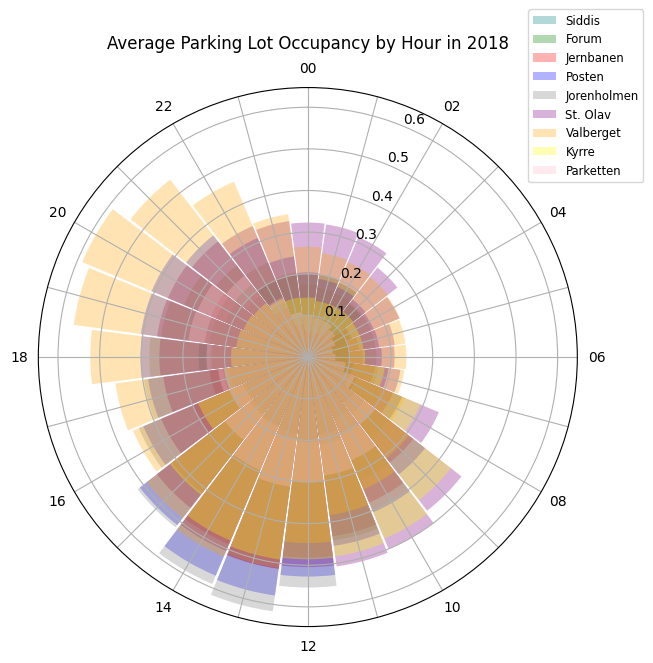

In [360]:
angles = np.linspace(0, 2 * np.pi, 24, endpoint=False) #deler opp sirkel (2*pi) i 24 like store deler

fig, ax = plt.subplots(figsize=(7,7), subplot_kw={'projection': 'polar'})

i=0
for lot_avg in parkinglots_hourly_avg_2018:
    bars = ax.bar(angles, parkinglots_hourly_avg_2018[i].values, width=0.25, color=colors[i], alpha=0.3, label=parkinglots[i]) #alpha styrer gjennomsiktighetsgraden
    i += 1

ax.legend(loc='best', fontsize='small', bbox_to_anchor=(1,1), bbox_transform = fig.transFigure) #plasseres ut fra figurens akser, ikke Axes' akser
ax.set_title("Average Parking Lot Occupancy by Hour in 2018", va='bottom')
ax.set_xticks(angles)
ax.set_xticklabels(hours_every_other)

ax.set_theta_direction(-1)       # Clockwise
ax.set_theta_zero_location("N")  # 12 o'clock starts at top

plt.show()

We see that there by far the most cars in the Stavanger parking lots between 8 AM and 22 PM. Below, we see the distribion separated by parking lots. 

Observe that
- St.Olav and Forum seem to have more cars around the clock that for example Jernbanen or Jorenholden
- Kyrre has only a small part of the day with a significatn number of cars, which seems to be between 9 AM and 15 PM
- The parking lots that seems to be most used, at least in terms of precentage used, is St.Olav, Posten and Valberget

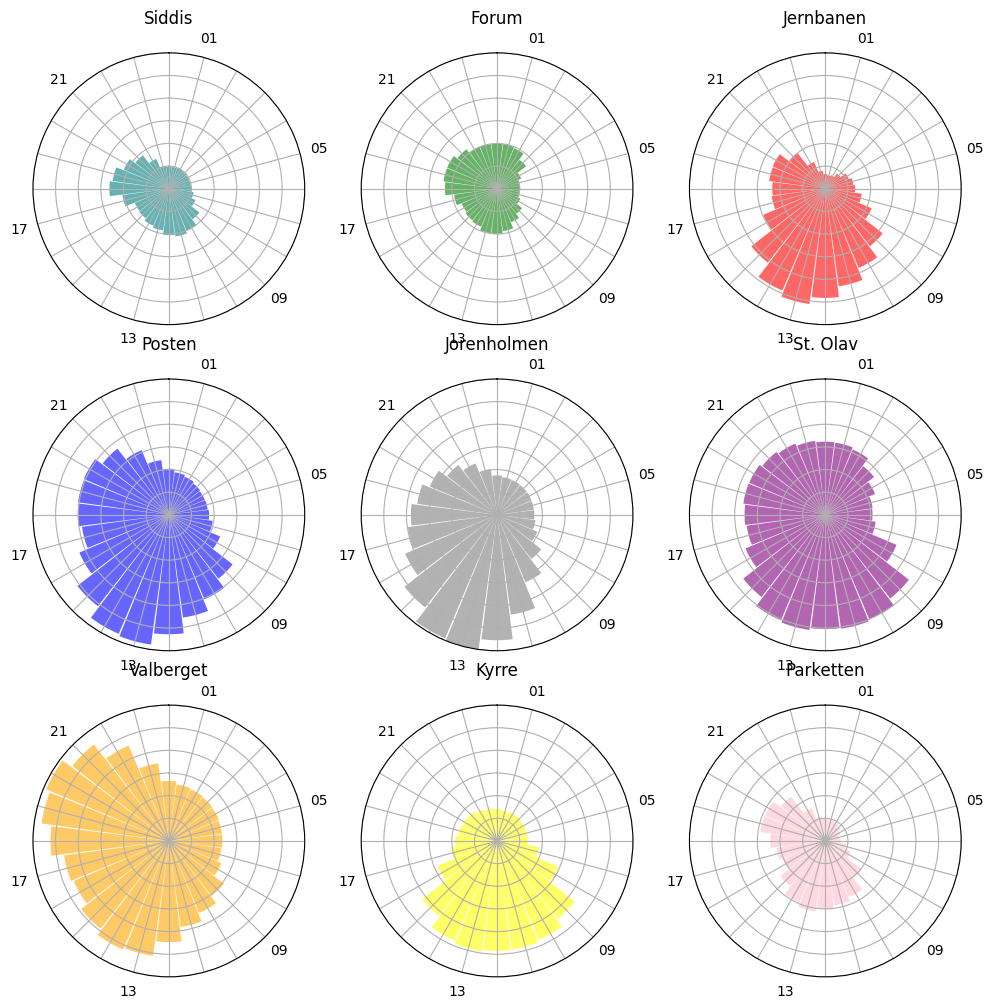

In [387]:
fig, ax = plt.subplots(3,3,figsize=(12,12), subplot_kw={'projection': 'polar'}, squeeze=False)

i = 0
j = 0
for k in range(9):
    ax[i,j].bar(angles, parkinglots_hourly_avg_2018[k].values, width=0.25, color=colors[k], alpha=0.6, label=parkinglots[k]) #alpha styrer gjennomsiktighetsgraden
    ax[i,j].set_title(parkinglots[k])
    
    ax[i,j].set_xticks(angles)
    ax[i,j].set_xticklabels(hours_every_four)
    # ax[i,j].set_xticklabels([])
    ax[i,j].set_yticklabels([])

    ax[i,j].set_rlim(0,0.6) #fixing the r-axis so all subplots have the same

    ax[i,j].set_theta_direction(-1)       # Clockwise
    ax[i,j].set_theta_zero_location("N")  # 12 o'clock starts at top

    j += 1

    if j == 3:
        i += 1
        j = 0

plt.show()

### The same, just in plotly

**Note:** Plotly express does not support multiple traces (graphs) in the same figure. For that we need to use Plotly Graph Objects.

In [ ]:
angles360 = np.linspace(0, 360, 24, endpoint=False) #deler opp sirkel (360) i 24 like store deler

fig = px.bar_polar(
    parkering2018,
    r = parkering2018.groupby('Tid')['Siddis'].mean().values,
    theta = angles360, 
    color=parkering2018.groupby('Tid')['Siddis'].mean().values
)

fig.update_traces(overwrite=True, marker={"opacity": 0.4})

fig.show()

### 2017 vs 2018

We will try to see if there has been any exciting changes in the hourly averages from 2017 and 2018. 

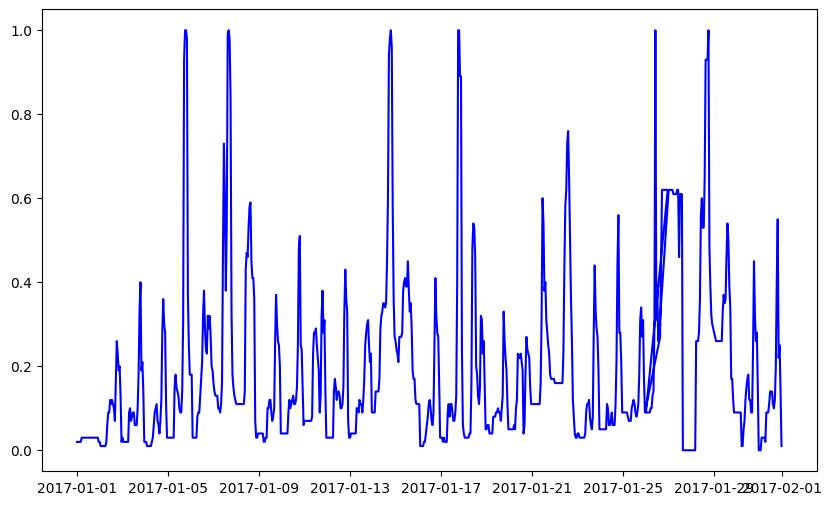

In [ ]:
jan2017 = parkering2017[ parkering2017['Tidspunkt'].dt.month == 1]
x1 = jan2017['Tidspunkt']
x2 = parkering2018['Tidspunkt']

y1 = jan2017['Siddis']
y2 = parkering2018['Siddis']

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(x1,y1,'b')
# ax.plot(x2,y2,'b')

plt.show()

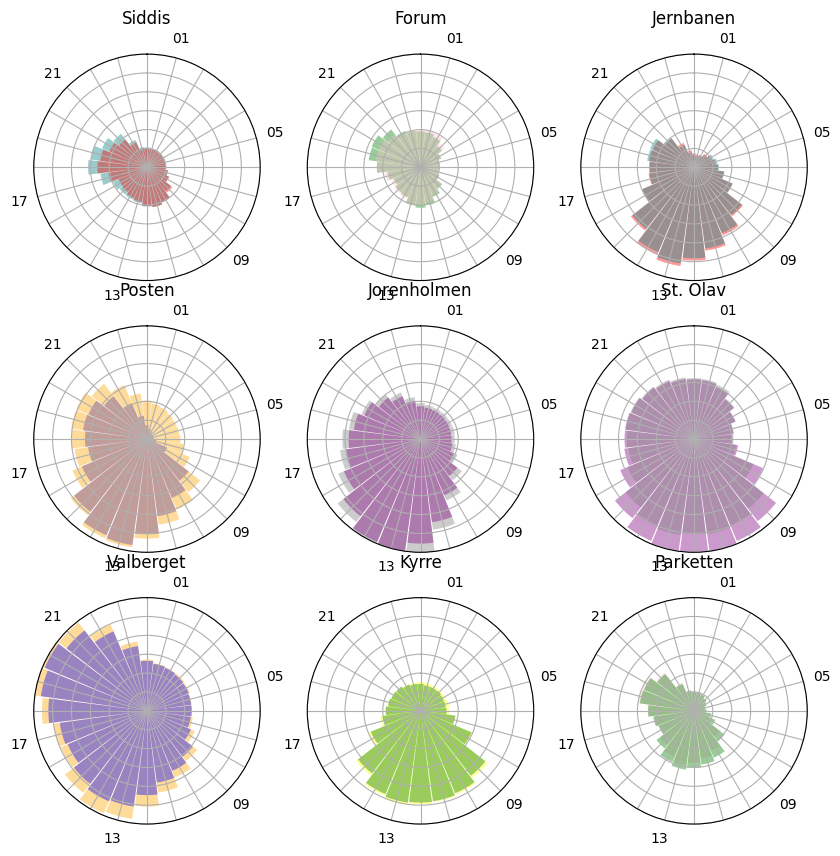

In [405]:
fig, ax = plt.subplots(3,3,figsize=(10,10), subplot_kw={'projection': 'polar'}, squeeze=False)

i = 0
j = 0
for k in range(9):
    ax[i,j].bar(angles, parkinglots_hourly_avg_2017[k].values, width=0.25, color=colors[k], alpha=0.4, label=parkinglots[k]) #alpha styrer gjennomsiktighetsgraden
    ax[i,j].bar(angles, parkinglots_hourly_avg_2018[k].values, width=0.25, color=colors2[k], alpha=0.4, label=parkinglots[k]) #alpha styrer gjennomsiktighetsgraden
    ax[i,j].set_title(parkinglots[k])
    
    ax[i,j].set_xticks(angles)
    ax[i,j].set_xticklabels(hours_every_four)
    # ax[i,j].set_xticklabels([])
    ax[i,j].set_yticklabels([])

    ax[i,j].set_rlim(0,0.6) #fixing the r-axis so all subplots have the same

    ax[i,j].set_theta_direction(-1)       # Clockwise
    ax[i,j].set_theta_zero_location("N")  # 12 o'clock starts at top

    j += 1

    if j == 3:
        i += 1
        j = 0

plt.show()

## St Olavs 2017 vs 2018

After cheating, and checking out some graphs in Power Bi, I decided to take a closer look at St.Olav. 

This is only beause this is the only parking lot where anything exciting happened between 2017 and 2018: the hourerly average coverage went significantly down. 

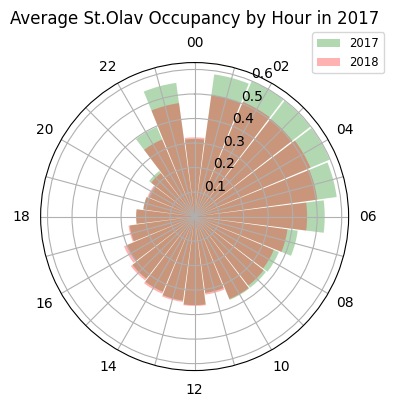

In [401]:
StOlav_hour_average_2017 = parkering2017.groupby('Tid')['St. Olav'].mean()
StOlav_hour_average_2018 = parkering2018.groupby('Tid')['St. Olav'].mean()

fig, ax = plt.subplots(figsize=(4,4), subplot_kw={'projection': 'polar'})

bars = ax.bar(angles, StOlav_hour_average_2017, width=0.25, color=colors[1], alpha=0.3, label='2017') #alpha styrer gjennomsiktighetsgraden
bars = ax.bar(angles, StOlav_hour_average_2018, width=0.25, color=colors[2], alpha=0.3, label ='2018') #alpha styrer gjennomsiktighetsgraden

ax.legend(loc='best', fontsize='small', bbox_to_anchor=(1,0.97), bbox_transform = fig.transFigure) #plasseres ut fra figurens akser, ikke Axes' akser

# Optional: Customize
ax.set_theta_zero_location("N")  # 12 o'clock starts at top
ax.set_theta_direction(-1)       # Clockwise
ax.set_xticks(angles)
ax.set_xticklabels(hours_every_other)
ax.set_title("Average St.Olav Occupancy by Hour in 2017", va='bottom')

plt.show()

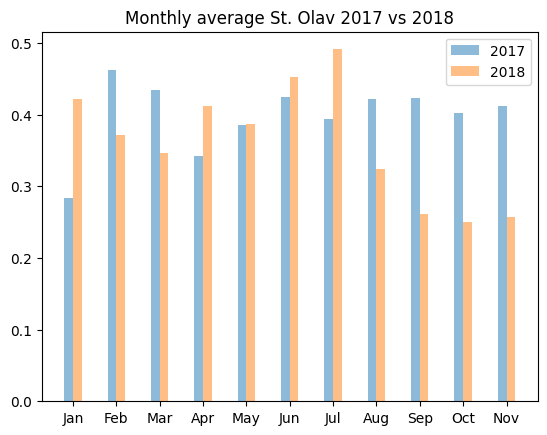

In [ ]:
## St. Olav occupancy by monthly averages
StOlav_hour_average_2017 = parkering2017.groupby('Month')['St. Olav'].mean()
StOlav_hour_average_2018 = parkering2018.groupby('Month')['St. Olav'].mean() #2018 mangler data for desember

fig,ax = plt.subplots()

w, x = 0.2, np.arange(len(months)-1)

# ax.bar(months[:-1], siddis_monthly_average_2017.values[:-1], label='2017', width=0.2, alpha=0.5)
# ax.bar(months[:-1], siddis_monthly_average_2018.values, label='2018', width=0.2, alpha=0.5)
ax.bar(x-w/2, StOlav_hour_average_2017.values[:-1], label='2017', width=0.2, alpha=0.5)
ax.bar(x+w/2, StOlav_hour_average_2018.values, label='2018', width=0.2, alpha=0.5)

ax.set_xticks(ticks=x, labels=months[:-1])
ax.set_title("Monthly average St. Olav 2017 vs 2018")
ax.legend()

plt.show()